# Towards Linear programming and Reinforcement learning

In [0]:
from random import randint
import math
import matplotlib.pyplot as plt
import numpy as np
import itertools
!pip install pulp
import pulp

## Problem set-up:

#### I- Transport 

Define $x_{ij}$ to be the number of units shipped from supply center $i$ to demand center $j$. The problem is to identify the
minimum cost shipping schedule. The constraints are that you must (at least) meet demand at each demand center and cannot exceed supply at each supply center. 

- The cost of the schedule, by the linearity assumption, is given by:

$min \sum_{i=1}^{m}\sum_{j=1}^{n}x_{ij}c_{ij}$

- Demand have to be respected (you have to exeed demand $D_j$ needed in $j$ while shipping to $j$):

$\sum_{i=1}^{m}x_{ij} > D_j $

- Supply as well (you cannot exeed the supply $S_i$ available in $i$ when shipping from $i$):

$\sum_{j=1}^{n}x_{ij} < S_i $


#### II- Control

  Also, we are interested in controlling the supply by choosing at each time step the amount of goods to produce to be injected in supply centers. We suppose that the demand is stochastic and follows a multinomial probability distribution. The usage of reinforcement learning conduces to the following formulation:


- States : $\{ \{S_i\}_t , \{D_j\}_t, status \}_{t \in \mathbf{R}{+}}$ the set of states
- Actions: ${A_i}$ the set of actions of dimension $n$
- Reward: if the status of the linear program is infeasible, then reward is -30, otherwise the goal is to avoid unnecessary stock so $R(s) = 1/\sum_i S_i$ 


The transitions from one state to another consist in:

- Solving the linear program to find $S_i \mapsto S_i - \sum_j x_{ij} + A_i$
- Sampling new demand values ${D_j}$
- Find if the next $S , D$ linear program status



We begin by defining the class that describes the game transitions and the that involves the linear program:



In [0]:
class buy_sell_game():
    #action corresponds to the quantity to produce for the supplier
    #state:  S_i , D_j , obj, lp_status, x_ij
    def __init__(self):  
        self.obj = 0
        self.lp_status = 'Optimal'
        self.supply_i = [0,1,2]
        self.demand_j = [0,1,2]
        self.S_i = [7 for i in range(len(self.supply_i))]
        self.D_j = [5 for j in range(len(self.demand_j))]
        self.x_ij = [[0., 0., 0.],[0., 0., 0.],[0., 0., 0.]]
        #self.state = (self.x_ij, self.S_i, self.D_j, self.lp_status, self.obj)
        self.state = ( self.S_i, self.D_j, self.lp_status)#, self.obj)

        self.isTerminal = False
        
    def step(self,state):
        #print(state)
        prob = pulp.LpProblem("Supply and demand problem", pulp.LpMinimize)
        
        cost = {(i,j):  (i+j)**2   for (i,j) in itertools.product(self.supply_i,self.demand_j) }
        var = {(i,j): pulp.LpVariable("unit shipped from supply "+str(i)+" to demand "+str(j),lowBound=0, cat=pulp.LpInteger) for (i,j) in itertools.product(self.supply_i,self.demand_j)}

        prob += pulp.lpSum([cost[i,j]*var[i,j] for (i,j) in itertools.product(self.supply_i,self.demand_j)]),"Objective function"

        for j in self.demand_j:
            prob += pulp.lpSum([var[i,j] for i in range(len(self.supply_i))]) >= state[1][j],"" # D_j

        for i in self.supply_i:
            prob += pulp.lpSum([var[i,j] for j in range(len(self.demand_j))]) <= state[0][i],""  #S_i
        prob.solve()
        #print(self.lp_status)

        return (pulp.value(prob.objective), np.array([v.varValue for v in prob.variables()]).reshape(len(self.supply_i),len(self.demand_j)) , pulp.LpStatus[prob.status])
   
    def D_transition(self):
        D= [np.argmax(np.random.multinomial(1,[0,0,0,0.2,0.4,0.3,0.1],size= 1)) for j in range(len(self.demand_j))]
        return D
       
    def S_transition(self,S,x):
        next_S = S - np.sum(x,axis =0)
        return next_S
    
    def next_state(self,state,action):     
        obj, x_ij, status = self.step(state)  # transport of produced goods
        
        next_S = self.S_transition(state[0],x_ij) + action
        next_D = self.D_transition()
        
        S_i = next_S
        D_j = next_D
        status = self.step((S_i,D_j,None))[2]
        
        #next_state = (x_ij, self.S_i ,self.D_j, status, obj)
        next_state = ( S_i ,D_j, status)#, obj)
        
        #if save == True:
        #    self.state = next_state
        return next_state

    def available_move(self,state):
        allActions = list(itertools.product([0,1,2,3,4,5,6],repeat = len(self.demand_j)))
        #possibleActions = list(filter(lambda x: self.next_state(state,x,False)[2] == 'Optimal',allActions))
        #print(possibleActions)
        return allActions
    
    def reward(self,state):
        if state[2] == 'Infeasible':
            reward = -30
        if state[2] == 'Optimal':
            #reward = self.obj + lamb*np.linalg.norm(self.S_i - np.sum(self.x_ij,axis =0),2)
            #reward = 100/(1+np.linalg.norm(state[0])-np.linalg.norm(state[1]))# - np.sum(self.x_ij,axis =0),2)
            if state[0][0] < 0 or state[0][1] <0 or state[0][2]<0:
                reward = -10 # No more stock in one place, non physical 
            else:
                stock = np.sum(state[0])#state[0][0] + state[0][1] + state[0][2]
                #demand = state[1][0] + state[1][1] + state[1][2]
                reward = 10/stock #- demand + 0.05)
                if reward > 0.8: #sinon c'est pile
                    reward = 0.6 

        return reward

### Monte Carlo Tree Search
Credit for MCTS: https://github.com/erachelson/RLclass/blob/master/RL5%20-%20Monte%20Carlo%20Tree%20Search.ipynb N.Schneider and E.Rachelson

To solve the control problem on top of the linear program at each time step, we use Monte Carlo Tree Search for the reinforcement learning . MCTS needs 4 methods in order to build the graph:

- Selection
- Expansion
- Simulation
- Backpropagation

Each node in the graph is a state, and a transition is observed by building child nodes each time there is an expansion. 

Here, the trade-off between exploration and exploitation is made through the Upper Confidence Bound for Trees and has the following formula:

$UCB_1 = \frac{r_i}{n_i} + \sqrt(2\frac{ln(n)}{n_i})$
 Where $n$ is the overall number of plays so far, $n_i$ the number of times this nod has been played, and $r_i$ the reward observed during this play. 



In [0]:
class mcts_custom():
    
    def __init__(self,game):
        #self.constant = math.sqrt(2)
        self.game = game
        self.states = [game.state]
        self.graphe = {str(game.state): []}
        self.reward_perstate = {str(game.state) : 0}
        self.plays = {str(game.state) : 0}
        
    def selection(self, current_simulated_state, visited_state):
        fils_nodes = self.graphe.get(str(current_simulated_state), 0)  # [s, s, s, ...]
        
        while fils_nodes != 0 and len(fils_nodes) != 0:
            visited_state.append(current_simulated_state)

            
            moves = self.game.available_move(current_simulated_state)  # mouvements autorisés
            if len(moves) != 0:  # il existe des fils non visités
                if randint(0, 10) <= 3:  # proba 0.2 d'explorer d'autre fils
                    # on garde le noeud courant comme selection à partir duquel on va faire l'expansion
                    return current_simulated_state, visited_state  # s, [s, s, s, ...]

            # on selectionne selon la formule UCB1 qui minimise la deception
            len_total = math.log(sum(self.plays[str(s[1])] for s in fils_nodes))
            max_value = -99999
            best_node = ()
            for s in fils_nodes:
                UCB1_value = (self.reward_perstate[str(s[1])] / self.plays[str(s[1])]) + math.sqrt(2) * math.sqrt(len_total / self.plays[str(s[1])])
                if UCB1_value >= max_value:
                    max_value = UCB1_value
                    best_node = s[1]

            current_simulated_state = best_node
            fils_nodes = self.graphe.get(str(current_simulated_state), 0)
        return current_simulated_state, visited_state  # s, [s, s, s, ...]
    
    def expension(self, current_simulated_state, visited_state):
        moves = self.game.available_move(current_simulated_state)  # mouvements autorisés
        fils_nodes = self.graphe.get(str(current_simulated_state), 0)  # [(a,s), (a,s), (a,s), ...]
        # cas d'exploration: a été choisi un noeud ou toutes les actions n'ont pas été explorées
        if (fils_nodes != 0):
            for fils_node in fils_nodes:
                moves.remove(fils_node[0])  # on retire les actions déjà visitées (ie: dont le fils existe)
        etat = current_simulated_state
        
        if (len(moves) != 0):
            # aleatoirement on choisit une action et developpons un nouvel état
            action = moves[randint(0, len(moves) - 1)]
            etat = self.game.next_state(current_simulated_state, action)
            visited_state.append(etat)
            # que l'on ajoute à la liste des états avec des stats egal à 0
            self.states.append(etat)
            # et mettons à jour le graphe
            fils = self.graphe.get(str(current_simulated_state), [])
            self.graphe[str(current_simulated_state)] = fils + [(action, etat)]  # on enregistre le fils dans le graphe
            self.graphe[str(etat)] = []
            self.reward_perstate[str(etat)] = 0
            self.plays[str(etat)] = 0
        return etat, visited_state
    
    
    def simulation(self, current_simulated_state):
        payoff = self.game.reward( current_simulated_state)
        # Monte carlo simulation, On choisit aleatoirement des actions jusqu'au critère d'arret: fin du jeu
        while(payoff == -1):
            moves = self.game.available_move(current_simulated_state)  # mouvements autorisés
            if (len(moves)!=0):
                # aleatoirement on choisit une action et developpons un nouvel état
                action = moves[randint(0, len(moves) - 1)]
                etat = self.game.next_state(current_simulated_state, action)
                # mise à jour de l'état courant
                current_simulated_state = etat
            
            payoff = self.game.reward( current_simulated_state)
        return payoff
    
    
    def back_propagation(self, visited_state, payoff):
        for state in visited_state:
            # mise a jour de la valeur play
            playsState = self.plays.get(str(state), 0)
            self.plays[str(state)] = playsState + 1
            # mise a jour de la valeur win en function du joueur
            
            winsState = self.reward_perstate.get(str(state), 0)
            self.reward_perstate[str(state)] = winsState + payoff

    def play(self, current_state, n):
        self.current_state = current_state
        move = 0
        # on simule n partie (ie. on construit le graphe sur n partie)
        while (move < n):
            current_simulated_state = current_state
            visited_state = []
            #current_player = self.jeu.joueur(current_state)
            
            #while (self.jeu.payoff(current_player, current_simulated_state) == -1):
            current_simulated_state, visited_state = self.selection(current_simulated_state, visited_state)
            current_simulated_state, visited_state = self.expension(current_simulated_state, visited_state)
            payoff = self.simulation(current_simulated_state)
            self.back_propagation(visited_state, payoff)
            #current_player = self.jeu.joueur(current_simulated_state)
                
            move += 1
        potential_play = self.graphe[str(current_state)]
        max_value = -99999
        best_action = 0
        for (a, s) in potential_play:
            value = (self.reward_perstate[str(s)] / self.plays[str(s)])
        #    print("Action:", a, "\twins,plays:", self.reward_perstate[str(s)], "/", 
        #          self.plays[str(s)], "\tvalue: %.3f" % value, "\tnb Etat:", len(self.graphe.keys()),
         #        "    \State:",s)
            if value >= max_value:
                max_value = value
                best_action = a
        return best_action  

We defined the two classes that we needed in order to solve the problem, now we play some scenarios, observe transitions and save buffer:

In [0]:
def play_scenario(n,parties):
    buffer = []
    jeu = buy_sell_game()
    print('New_game')
    mcts = mcts_custom(jeu)
    for ii in range(parties):
        state = jeu.state
        reward = jeu.reward(jeu.state)
        action = mcts.play(state, n)
        next_state = jeu.next_state(state,action)
        print(state,action,reward)
        #action = [4,4,4]
        buffer.append([state,action,reward,next_state])
        jeu.state = next_state
    return buffer, mcts
    
        



In [0]:
buffer, mcts = play_scenario(300,100)

New_game


/usr/local/lib/python3.6/dist-packages/pulp/pulp.py:1137: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


([7, 7, 7], [5, 5, 5], 'Optimal') (1, 6, 1) 0.47619047619047616
(array([3., 8., 3.]), [4, 5, 3], 'Optimal') (4, 6, 4) 0.7142857142857143
(array([3., 9., 4.]), [4, 5, 5], 'Optimal') (3, 6, 3) 0.625
(array([ 2., 10.,  2.]), [4, 4, 4], 'Optimal') (3, 6, 5) 0.7142857142857143
(array([ 1., 12.,  3.]), [3, 4, 4], 'Optimal') (4, 6, 2) 0.625
(array([ 2., 14.,  1.]), [5, 5, 6], 'Optimal') (6, 3, 6) 0.5882352941176471
(array([ 3., 12.,  1.]), [3, 6, 4], 'Optimal') (3, 2, 6) 0.625
(array([3., 8., 3.]), [6, 5, 5], 'Infeasible') (6, 6, 5) -30
(array([3., 9., 3.]), [3, 3, 4], 'Optimal') (6, 3, 1) 0.6666666666666666
(array([6., 9., 0.]), [5, 5, 4], 'Optimal') (5, 4, 5) 0.6666666666666666
(array([6., 8., 1.]), [6, 5, 4], 'Optimal') (6, 6, 6) 0.6666666666666666
(array([6., 9., 3.]), [5, 5, 4], 'Optimal') (2, 6, 2) 0.5555555555555556
(array([ 3., 10.,  1.]), [6, 5, 3], 'Optimal') (4, 4, 6) 0.7142857142857143
(array([1., 9., 4.]), [5, 5, 4], 'Optimal') (6, 5, 3) 0.7142857142857143
(array([2., 9., 3.]), [

In [0]:
S = [buffer[i][0][0] for i in range(100)]
D = [buffer[i][0][1] for i in range(100)]
Statuss = [buffer[i][0][2] for i in range(100)]
Actions = [buffer[i][1] for i in range(100)]
Rewards = [buffer[i][2] for i in range(100)]

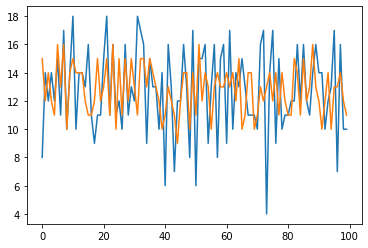

In [0]:
import matplotlib.pyplot as plt
plt.plot([np.sum(action) for action in Actions])
plt.plot([np.sum(demand) for demand in D])
plt.show()

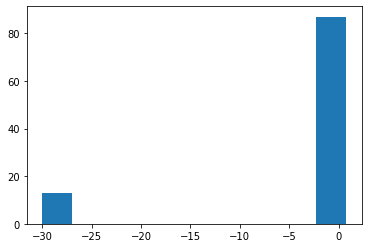

In [0]:
plt.hist(Rewards)
plt.show()

In [0]:
sum([np.sum(action) for action in Actions])

1275

In [0]:
sum([np.sum(demand) for demand in D])

1281

In [0]:
sum([np.sum(supply) for supply in S])

1547.0

In [0]:
import graphviz as gv
dot = gv.Graph(format='png')
i=0
stateDot = {}
for state in mcts.graphe:
    stateDot[state]=i
    i+=1
for state in mcts.graphe:
    dot.node(str(stateDot[state]))#, str(nb_non_zero(state)))
  #  for fils in mcts.graphe[state]:
  #      dot.edge(str(stateDot[state]), str(stateDot[fils[1]]))#, str(fils[0]))
filename = dot.render(filename='g1')
print(filename)
dot.render('graphe.gv', view=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.011167 to fit


g1.png


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.011167 to fit


'graphe.gv.png'

In [0]:
list(mcts.graphe.values())

[[((4, 0, 5), (array([6., 2., 7.]), [4, 5, 3], 'Optimal')),
  ((2, 1, 1), (array([4., 3., 3.]), [4, 3, 4], 'Infeasible')),
  ((0, 0, 6), (array([2., 2., 8.]), [4, 4, 3], 'Optimal')),
  ((6, 4, 3), (array([8., 6., 5.]), [5, 4, 4], 'Optimal')),
  ((1, 4, 5), (array([3., 6., 7.]), [4, 6, 3], 'Optimal')),
  ((1, 0, 4), (array([3., 2., 6.]), [5, 4, 4], 'Infeasible')),
  ((6, 1, 3), (array([8., 3., 5.]), [4, 4, 4], 'Optimal')),
  ((4, 3, 1), (array([6., 5., 3.]), [5, 3, 3], 'Optimal')),
  ((1, 4, 4), (array([3., 6., 6.]), [5, 6, 3], 'Optimal')),
  ((3, 5, 0), (array([5., 7., 2.]), [4, 3, 3], 'Optimal')),
  ((1, 5, 4), (array([3., 7., 6.]), [4, 3, 3], 'Optimal')),
  ((3, 3, 1), (array([5., 5., 3.]), [5, 5, 4], 'Infeasible')),
  ((1, 1, 5), (array([3., 3., 7.]), [5, 4, 3], 'Optimal')),
  ((5, 0, 4), (array([7., 2., 6.]), [5, 6, 5], 'Infeasible')),
  ((3, 4, 5), (array([5., 6., 7.]), [4, 4, 4], 'Optimal')),
  ((3, 4, 6), (array([5., 6., 8.]), [4, 6, 4], 'Optimal')),
  ((3, 3, 4), (array([5., 5.